In [1]:
import os
import sys
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import dataframe_image as dfi

In [2]:
#for this script to correctly find the .py files with the following functions, you must run this script from the folder that contains all the scripts
import CPP_functions
import resp_and_cardiac_plotting_functions

Python environment: clustering

# Split into train/test before zscoring so the test data's distribution doesn't leak into the train set

Even though the train/test split is not actually necessary until we get to the decision tree analysis, we have to decide our split now, before doing any zscoring of the physiology data for any further analysis. Otherwise, the process of zscoring will introduce information about the whole dataset into our test set, thereby slightly compromising the independence of our test data.

In [3]:
#load csv of phgy metrics
phgy_arr_selectvar = pd.read_csv('../../4_derivatives/final_phgy_censored/phgy_metrics_final_csv/phgy_metrics_noZscore_selectvar_phgyfmriCensored.csv')
session_info_arr = pd.read_csv('../../4_derivatives/final_phgy_censored/phgy_metrics_final_csv/session_info_phgyfmriCensored.csv')

In [4]:
#reset all indices to properly track timepoint number
phgy_arr_selectvar = phgy_arr_selectvar.reset_index(drop = True)
session_info_arr = session_info_arr.reset_index(drop = True)

In [5]:
#import the CAP outputs and calculate network detectability so that you can stratify the train test split based on that
CAP_df = pd.read_csv('./CAP_analysis/CAP_metrics_KMeansCorr.csv').drop("Unnamed: 0",axis=1)
CAP_df['network detected'] = np.abs(CAP_df['Corr-networkAvg'])>0.1

In [6]:
#extract only the raw phgy columns
numeric_cols = phgy_arr_selectvar.select_dtypes(include=[np.number]).columns

In [7]:
phgy_train, phgy_test, network_detectability_train, network_detectability_test = CPP_functions.custom_stratified_train_test_split_with_group(X = phgy_arr_selectvar[numeric_cols], y = CAP_df['network detected'],
                                                                                                group = session_info_arr['session_ID'],   random_state = 1)

Initial test groups: [ 5  3 29 45 22 34 25 40 36 28], train-full divergence: 0.004063259975898231 test-full divergence: 0.013055908477975954
Better combo found at : 3 with groups: (1, 6, 11, 19, 20, 29, 36, 40, 42, 44), train-full divergence: 0.004106677576385016 test-full divergence: 0.012477090900254137
Better combo found at : 8 with groups: (3, 8, 11, 15, 16, 18, 19, 29, 30, 44), train-full divergence: 0.002395942607057865 test-full divergence: 0.0076279977716647174
Better combo found at : 19 with groups: (3, 10, 12, 15, 23, 28, 31, 38, 39, 46), train-full divergence: 0.0018083612684690635 test-full divergence: 0.005325874668771517
Better combo found at : 33 with groups: (13, 14, 18, 22, 26, 36, 38, 39, 40, 43), train-full divergence: 0.001140495701089312 test-full divergence: 0.0033665588089660157
Better combo found at : 44 with groups: (2, 10, 14, 18, 23, 30, 32, 39, 40, 45), train-full divergence: 0.0007834343376733983 test-full divergence: 0.002323860252919514
Better combo found

Both the train, test and original dataset have 0.222% of the set is timepoints with a network.

# Zscore on a strain/sex basis or dataset basis

In [8]:
#zscore the train and test sets separately
phgy_train_dataset_zscored = (phgy_train - np.mean(phgy_train))/np.std(phgy_train)
phgy_test_dataset_zscored = (phgy_test - np.mean(phgy_train))/np.std(phgy_train)

Num timepoints c57m (train): 9306Num timepoints c57f (train): 11671
Num timepoints c3m (train): 6711Num timepoints c3f (train): 11700
Num timepoints c57m (test): 2637Num timepoints c57f (test): 0
Num timepoints c3m (test): 6740Num timepoints c3f (test): 3841
                     SpO2     PVI       HR    HRV     RV       RR    RRV
C57Bl/6 males      82.101   83.69  290.054  0.052  8.675  102.592  0.033
C57Bl/6 females    81.697  73.816  306.561  0.036  2.751    126.5   0.02
C3HeB/FeJ males    91.227  69.831  208.943  0.057  8.545   84.714  0.037
C3HeB/FeJ females  87.014  83.054  236.676  0.055  7.507    84.38   0.05
                     SpO2     PVI      HR    HRV     RV      RR    RRV
C57Bl/6 males      14.651  12.491   39.07  0.027  4.323  16.114  0.032
C57Bl/6 females     9.668   17.63  41.372  0.036  1.454  14.591  0.021
C3HeB/FeJ males     2.875  14.894  18.926  0.026  3.091   8.338  0.027
C3HeB/FeJ females   6.179  10.542  27.935  0.033  2.603  11.521  0.055


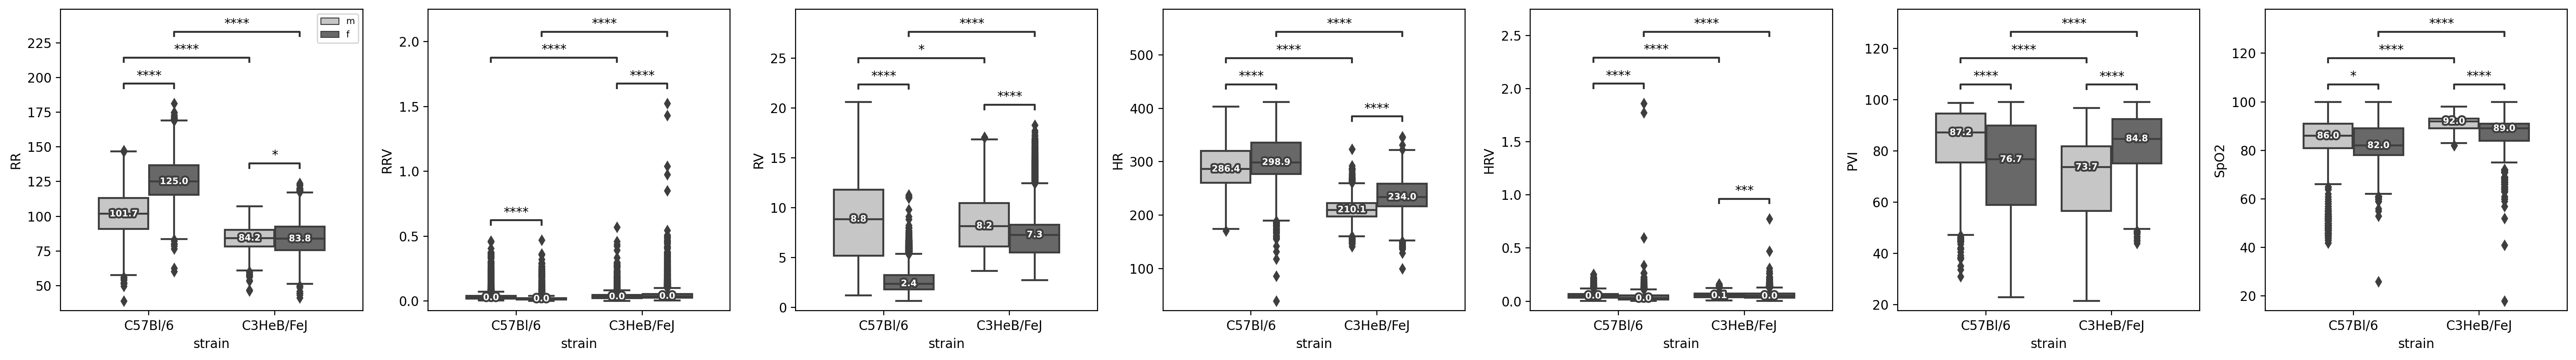

In [9]:
#output the balance of male/female of each strain in the train and test set
#also output the raw value of each phgy metric before zscore, and after zscore.
phgy_train_sexstrain_zscored, phgy_test_sexstrain_zscored, mean_summary_df, std_summary_df = CPP_functions.zscore_by_sex_strain(phgy_train, phgy_test, 
                                                                                                                                session_info_arr)

In [10]:
#output the average and std of each phgy metric in each group for the paper supplementary
#this is necessary for the interpretaton of the zscored values
dfi.export(mean_summary_df, './final_output/figures_for_paper/phgy_zscoring_table_means.png')
dfi.export(std_summary_df, './final_output/figures_for_paper/phgy_zscoring_table_std.png')

In [11]:
#combine the train and test set for the physiology clustering (we will only need them separate for the decision tree)
phgy_dataset_zscore = pd.concat([phgy_train_dataset_zscored, phgy_test_dataset_zscored]).sort_index()
phgy_sexstrain_zscore = pd.concat([phgy_train_sexstrain_zscored, phgy_test_sexstrain_zscored]).sort_index()

# Choose cluster size based on silhouette analysis

In [ ]:
#in practice, it is more efficient to run this with the run-CPP_ncluster_selection.sh joblist in qbatch
n_clusters=int(sys.argv[1])
CPP_functions.silhouette_analysis(phgy_train_dataset_zscored.to_numpy(), list(range(n_clusters,n_clusters+1,1)), session_info_arr, 
                    './intermediary_outputs_for_sanity_check/CPP_ncluster_selection_dataset_zscored/')
CPP_functions.silhouette_analysis(phgy_train_sexstrain_zscored.to_numpy(), list(range(n_clusters,n_clusters+1,1)), session_info_arr, 
                    './intermediary_outputs_for_sanity_check/CPP_ncluster_selection_sexstrain_zscored/')

Conclusion: 5 clusters gives the highest score (at least for the zscored version). For the non-zscored version, it also gives 5 clusters

# Output the cluster characteristics and timecourses

In [ ]:
#load the necessary pickle files
phgy_dict_postCensor_shape = pickle.load(open("../../4_derivatives/final_phgy_censored/pickle_files/phgy_dict_postCensor_shape_withEdgeCutoff", "rb"))

In [ ]:
cluster_axs_order_dict_zscore = {'0': 0, '1': 1, '2':2, '3':3, '4': 4}
session_info_df_mod_sexstrainzscore, corr, pred = CPP_functions.phgy_cluster_characteristics('./intermediary_outputs_for_sanity_check/CPP_ncluster_selection_sexstrain_zscored/kmeans_cluster_object_5cluster', phgy_sexstrain_zscore,
                                                                                 5, session_info_arr,
                                                                                phgy_dict_postCensor_shape,
                                                                                './intermediary_outputs_for_sanity_check/CPP_5cluster_characteristics_sexstrain_zscore',
                                                                                './final_output/CPP_metrics_5clust_sexstrain_zscore.csv',
                                                                                cluster_axs_order_dict_zscore)

# Print examples of resp/pulseox traces in each cluster

In [12]:
df = pd.read_csv('./final_output/CPP_metrics_5clust_sexstrain_zscore_new.csv')

#load the raw phgy traces
phgy_folder='../../3_preprocessed_data/phgy_data_oldNaming/'
resp_traces = sorted(glob.glob(phgy_folder + '/*resp*.txt'))
pulseox_traces = sorted(glob.glob(phgy_folder + '/*pulseox*.txt'))

#load the necessary pickle files
phgy_dict_postCensor_shape = pickle.load(open("../../4_derivatives/final_phgy_censored/pickle_files/phgy_dict_postCensor_shape_withEdgeCutoff", "rb"))
fmri_phgy_nan_censor = pickle.load(open("../../4_derivatives/final_phgy_censored/pickle_files/series_fmri_phgy_nan_censor", "rb"))
fmri_phgy_nan_censor_dict = pickle.load(open("../../4_derivatives/final_phgy_censored/pickle_files/dict_fmri_phgy_nan_censor", "rb"))
phgy_dict_selectvar_precensor= pickle.load(open("../../4_derivatives/final_phgy_censored/pickle_files/phgy_dict_selectvar_precensor", "rb"))
phgy_dict_selectvar= pickle.load(open("../../4_derivatives/final_phgy_censored/pickle_files/phgy_dict_selectvar", "rb"))

##### Determine ymin and ymax of the raw phgy traces so that I can set range properly

In [ ]:
i = 0
for csv in resp_traces:
    resp_df_toadd = resp_and_cardiac_plotting_functions.denoise_detrend_resp(pd.read_csv(csv, header = None)[0],
                                                                             int(324000/1440), True)
    if i == 0:
        all_resp_df = resp_df_toadd
    else:   
        all_resp_df = pd.concat([all_resp_df, resp_df_toadd])
    print("\r", str(csv), end = "")
    i = i+1
plt.hist(all_resp_df, bins = 100)
plt.title("Range to set ymin/ymax of resp trace plots")

In [ ]:
i = 0
for csv in pulseox_traces:
    pulseox_df_toadd = resp_and_cardiac_plotting_functions.denoise_cardiac(pd.read_csv(csv, header = None)[0],
                                                                           int(648000/1440), False)
    if i == 0:
        all_pulseox_df = pulseox_df_toadd
    else:   
        all_pulseox_df = pd.concat([all_pulseox_df, pulseox_df_toadd])
    print("\r", str(csv), end = "")
    i = i+1
plt.hist(all_pulseox_df, bins = 100)
plt.title("Range to set ymin/ymax of pulseox trace plots")

#### Uncensor the CPP cluster timeseries

The CPP clusters were derived on the censored timeseries of physiology data, so they too are censored (each timepoint from 
the input physiology metrics is assigned to a cluster). In order to plot the cluster timeseries with the proper time axis, I need to undo this censoring process.

In [13]:
def reverse_temporal_masking(df_masked, bool_masking):
    bool_df_masking = pd.DataFrame(bool_masking).reset_index(drop = True)
    num_variables_to_copy = len(df_masked.columns)
    unmasked_list = [[None]*num_variables_to_copy for _ in range(len(bool_masking))]
    index_censored = 0

    #iterate over all timepoints
    for index_uncensored, row in bool_df_masking.iterrows():

        #if that timepoint was censored (ie False), then set all the rows to Nan 
        if row[0] == False:
            unmasked_list[index_uncensored] = [np.NAN]*num_variables_to_copy

        #if that timepoint was not censored, then copy the row of values from the desired dataframe
        else:
            unmasked_list[index_uncensored] = df_masked.loc[index_censored].values.tolist()
            index_censored = index_censored + 1
        
        print("\r", "uncensored index: " + str(index_uncensored) + ', censored index: ' + str(index_censored) , end="")
    
    #convert the list to dataframe
    unmasked_df = pd.DataFrame(unmasked_list, columns = df_masked.columns)
    return unmasked_df


In [14]:
df_unmasked = reverse_temporal_masking(df, fmri_phgy_nan_censor)

 uncensored index: 66239, censored index: 52606

In [15]:
phgy_arr_selectvar_sexstrain_zscored_unmasked = reverse_temporal_masking(phgy_sexstrain_zscore, fmri_phgy_nan_censor)

 uncensored index: 66239, censored index: 52606

#### Now, can actually do the plotting

In [19]:
spo2_csvs = sorted(glob.glob('../../3_preprocessed_data/phgy_data_oldNaming/*spo2*'))
sub_start_index = 0
for sub_ses in phgy_dict_postCensor_shape.keys():
    filename = os.path.basename(os.path.abspath(sub_ses))
    sub = filename[7:10]
    ses = filename[15:16]
    string = 'dx' + str(ses) + '_' + str(sub)
    resp_with_string = [s for s in resp_traces if string in s][0]
    pulseox_with_string = [s for s in pulseox_traces if string in s][0]
    spo2_with_string = [s for s in spo2_csvs if string in s][0]

   
    #concatenate df of cluster info and that of phgy metrics for this subject
    full_phgy_df_sub = pd.concat([df.loc[df['index'] == str(sub_ses)], phgy_dict_selectvar[sub_ses].reset_index(drop = True)], axis = 1)
    print(string)
    print('processing ' + str(sub_ses) + ' with resp file ' + str(resp_with_string))
    CPP_functions.plot_CPP_and_raw_phgy('./intermediary_outputs_for_sanity_check/CPP_cluster_and_phgy_timecourses/phgy_trace_clusters_' + str(sub_ses), fmri_phgy_nan_censor_dict[sub_ses], phgy_dict_selectvar_precensor[sub_ses],
                        df_unmasked.loc[sub_start_index:sub_start_index + 1439], resp_with_string, pulseox_with_string, 5 )
    CPP_functions.plot_CPP_and_raw_phgy_zscore('./intermediary_outputs_for_sanity_check/CPP_cluster_and_phgy_timecourses/phgy_trace_clusters_' + str(sub_ses), fmri_phgy_nan_censor_dict[sub_ses], 
                          phgy_arr_selectvar_sexstrain_zscored_unmasked.loc[sub_start_index:sub_start_index + 1439],
                          df_unmasked.loc[sub_start_index:sub_start_index + 1439], resp_with_string, pulseox_with_string, 5 )
    sub_start_index = sub_start_index + 1440

dx1_001
processing sub-PHG001_ses-1 with resp file ../../3_preprocessed_data/phgy_data_oldNaming/dx1_001_resp_cleaned.txt
dx2_001
processing sub-PHG001_ses-2 with resp file ../../3_preprocessed_data/phgy_data_oldNaming/dx2_001_resp_cleaned.txt
dx3_001
processing sub-PHG001_ses-3 with resp file ../../3_preprocessed_data/phgy_data_oldNaming/dx3_001_resp_cleaned.txt
dx1_002
processing sub-PHG002_ses-1 with resp file ../../3_preprocessed_data/phgy_data_oldNaming/dx1_002_resp_cleaned.txt
dx2_002
processing sub-PHG002_ses-2 with resp file ../../3_preprocessed_data/phgy_data_oldNaming/dx2_002_resp_cleaned.txt
dx3_002
processing sub-PHG002_ses-3 with resp file ../../3_preprocessed_data/phgy_data_oldNaming/dx3_002_resp_v2_cleaned.txt
dx1_003
processing sub-PHG003_ses-1 with resp file ../../3_preprocessed_data/phgy_data_oldNaming/dx1_003_resp_cleaned.txt
dx2_003
processing sub-PHG003_ses-2 with resp file ../../3_preprocessed_data/phgy_data_oldNaming/dx2_003_resp_cleaned.txt
dx3_003
processing su

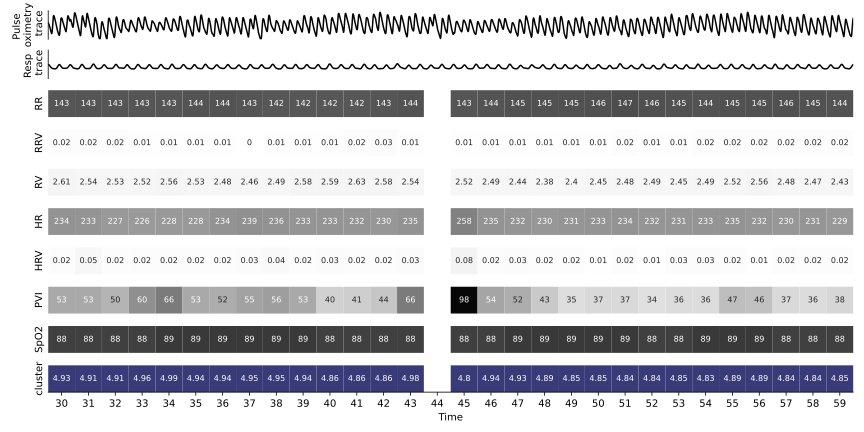

In [20]:
#plot one example of the cluster and phgy timecourses
from IPython.display import SVG, display
file_path = "./intermediary_outputs_for_sanity_check/CPP_cluster_and_phgy_timecourses/phgy_trace_clusters_sub-PHG001_ses-1-start30.svg"
display(SVG(filename=file_path))